# <div style="text-align: center"><font color='gray' textalign='center'>Lab 3: Classification</font></div>

In [1]:
import pandas as pd
import ds_functions as ds
import matplotlib.pyplot as plt

data = pd.read_csv('heart_failure_clinical_records_dataset.csv', sep = ',')

data["sex"] = data["sex"].astype("bool")
data["anaemia"] = data["anaemia"].astype("bool")
data["diabetes"] = data["diabetes"].astype("bool")
data["high_blood_pressure"] = data["high_blood_pressure"].astype("bool")
data["smoking"] = data["smoking"].astype("bool")
data["DEATH_EVENT"] = data["DEATH_EVENT"].astype("bool")

data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,False,582,False,20,True,265000.00,1.9,130,True,False,4,True
1,55.0,False,7861,False,38,False,263358.03,1.1,136,True,False,6,True
2,65.0,False,146,False,20,False,162000.00,1.3,129,True,True,7,True
3,50.0,True,111,False,20,False,210000.00,1.9,137,True,False,7,True
4,65.0,True,160,True,20,False,327000.00,2.7,116,False,False,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,False,61,True,38,True,155000.00,1.1,143,True,True,270,False
295,55.0,False,1820,False,38,False,270000.00,1.2,139,False,False,271,False
296,45.0,False,2060,True,60,False,742000.00,0.8,138,False,False,278,False
297,45.0,False,2413,False,38,False,140000.00,1.4,140,True,True,280,False


# <font color='gray'> Scaling </font>

In [2]:
cols_nr = data.select_dtypes(include='number')
cols_sb = data.select_dtypes(include='bool')
data.describe(include='all')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299,299.000000,299,299.000000,299,299.000000,299.00000,299.000000,299,299,299.000000,299
unique,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,2,2,NaN,2
top,NaN,False,NaN,False,NaN,False,NaN,NaN,NaN,True,False,NaN,False
freq,NaN,170,NaN,174,NaN,194,NaN,NaN,NaN,194,203,NaN,203
mean,60.833893,NaN,581.839465,NaN,38.083612,NaN,263358.029264,1.39388,136.625418,NaN,NaN,130.260870,NaN
std,11.894809,NaN,970.287881,NaN,11.834841,NaN,97804.236869,1.03451,4.412477,NaN,NaN,77.614208,NaN
min,40.000000,NaN,23.000000,NaN,14.000000,NaN,25100.000000,0.50000,113.000000,NaN,NaN,4.000000,NaN
25%,51.000000,NaN,116.500000,NaN,30.000000,NaN,212500.000000,0.90000,134.000000,NaN,NaN,73.000000,NaN
50%,60.000000,NaN,250.000000,NaN,38.000000,NaN,262000.000000,1.10000,137.000000,NaN,NaN,115.000000,NaN
75%,70.000000,NaN,582.000000,NaN,45.000000,NaN,303500.000000,1.40000,140.000000,NaN,NaN,203.000000,NaN


In [3]:
from sklearn.impute import SimpleImputer
import numpy as np

imp = SimpleImputer(strategy='constant', fill_value='NA', missing_values=np.nan, copy=True)
imp.fit(data.values)
mat = imp.transform(data.values)
data = pd.DataFrame(mat, columns=data.columns)
data.describe(include='all')


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.0,299,299,299,299,299,299.00,299.0,299,299,299,299,299
unique,47.0,2,208,2,17,2,176.00,40.0,27,2,2,148,2
top,60.0,False,582,False,35,False,263358.03,1.0,136,True,False,187,False
freq,33.0,170,47,174,49,194,25.00,50.0,40,194,203,7,203


In [4]:
imp_nr = SimpleImputer(strategy='mean', missing_values=np.nan, copy=True)
df_nr = pd.DataFrame(imp_nr.fit_transform(cols_nr), columns=cols_nr.columns)
df_sb = cols_sb
data = pd.concat([df_nr, df_sb], axis=1, sort=False)
data.describe(include='all')

data = data.sample(frac=1) #to randomize the dataset order
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 3 * IQR)) |(data > (Q3 + 3 * IQR))).any(axis=1)]

In [5]:
from sklearn.preprocessing import StandardScaler

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr.join(df_sb, how='right')
norm_data_zscore.describe(include='all')
data = norm_data_zscore

# <font color='gray'> Training Models </font>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)
labels.sort()

In [7]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5)

In [8]:
splits = []

for train_index, test_index in kf.split(X, y):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    splits.append([trnX, tstX, trnY, tstY])


# <font color='gray'> Naive Bayes - ZScore</font>

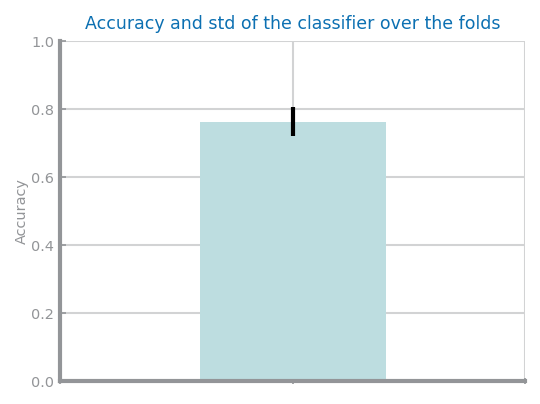

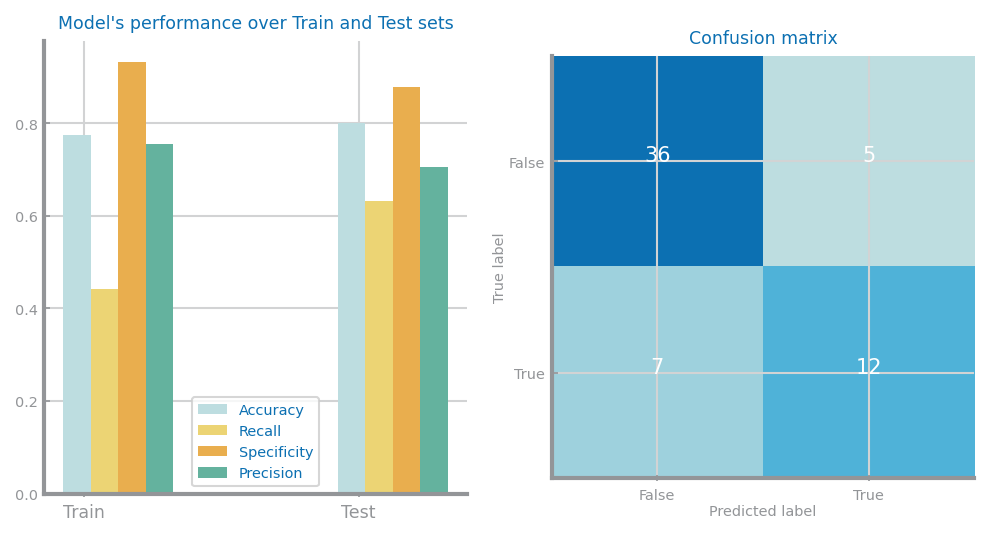

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import ds_functions as ds

y_hat_all = []
score_all = []
models = []
set_idxs = []
for trnX, tstX, trnY, tstY in splits:
    clf = GaussianNB()
    set_idxs.append([trnX, tstX, trnY, tstY])
    clf = clf.fit(trnX, trnY)
    models.append(clf)
    y_hat = clf.predict(trnX)
    y_hat_all.append(y_hat)
    score_all.append(clf.score(tstX, tstY))

best_model_idx = score_all.index(max(score_all))
best_model = models[best_model_idx]
set_idxs = set_idxs[best_model_idx]
prd_trn = best_model.predict(set_idxs[0])
prd_tst = best_model.predict(set_idxs[1])

fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()

ds.plot_evaluation_results(labels, set_idxs[2], prd_trn, set_idxs[3], prd_tst)

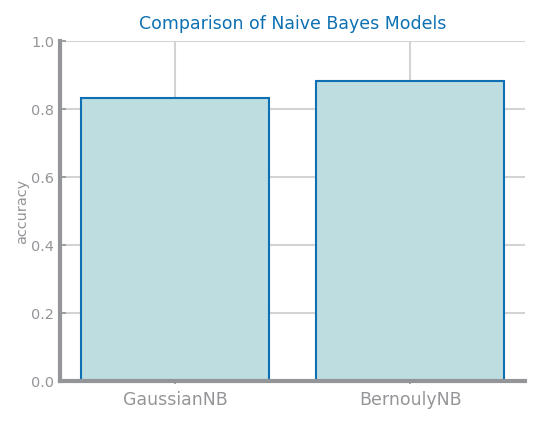

In [10]:
estimators = {'GaussianNB': GaussianNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    y_hat_all = []
    score_all = []
    models = []
    set_idxs = []
    for trnX, tstX, trnY, tstY in splits:
        model = estimators[clf]
        set_idxs.append([trnX, tstX, trnY, tstY])
        model = model.fit(trnX, trnY)
        models.append(model)
        y_hat = model.predict(tstX)
        y_hat_all.append(y_hat)
        score_all.append(model.score(tstX, tstY))
    
    best_model_idx = score_all.index(max(score_all))
    best_model = models[best_model_idx]
    set_idxs = set_idxs[best_model_idx]
    xvalues.append(clf)
    prdY = best_model.predict(set_idxs[1])
    yvalues.append(metrics.accuracy_score(set_idxs[3], prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'> KNN - ZScore</font>

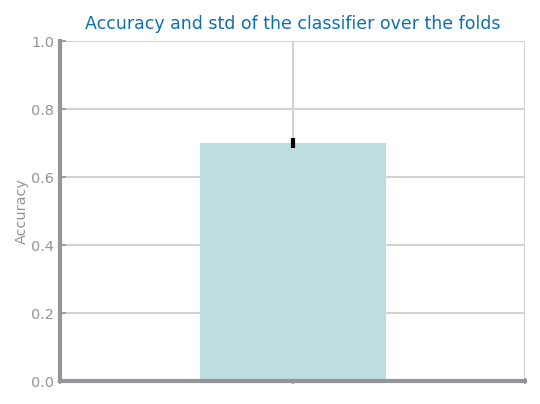

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

score_all = []
set_idxs = []
for trnX, tstX, trnY, tstY in splits:
    set_idxs.append([trnX, tstX, trnY, tstY])
    nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    values = {}
    train_values = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        yvalues = []
        y_trn_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(trnX, trnY)
            prdY = knn.predict(tstX)
            prd_trn_Y = knn.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (n, d)
                last_best = yvalues[-1]
        values[d] = yvalues
        train_values[d] = y_trn_values
    score_all.append(last_best)
    
best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]    

score_all = []
for trnX, tstX, trnY, tstY in splits:
    knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
    knn.fit(trnX, trnY)
    prdY = knn.predict(tstX)
    prd_trn_Y = knn.predict(trnX)
    score_all.append(metrics.accuracy_score(tstY, prdY))

fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()

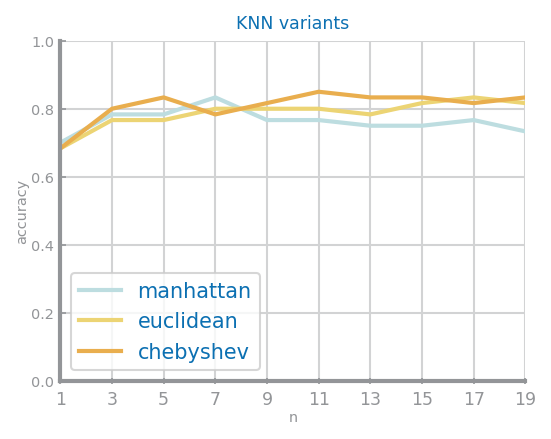

Best results with 11 neighbors and chebyshev


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

trnX, tstX, trnY, tstY = set_idxs
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
train_values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    y_trn_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        prd_trn_Y = knn.predict(trnX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues
    train_values[d] = y_trn_values

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

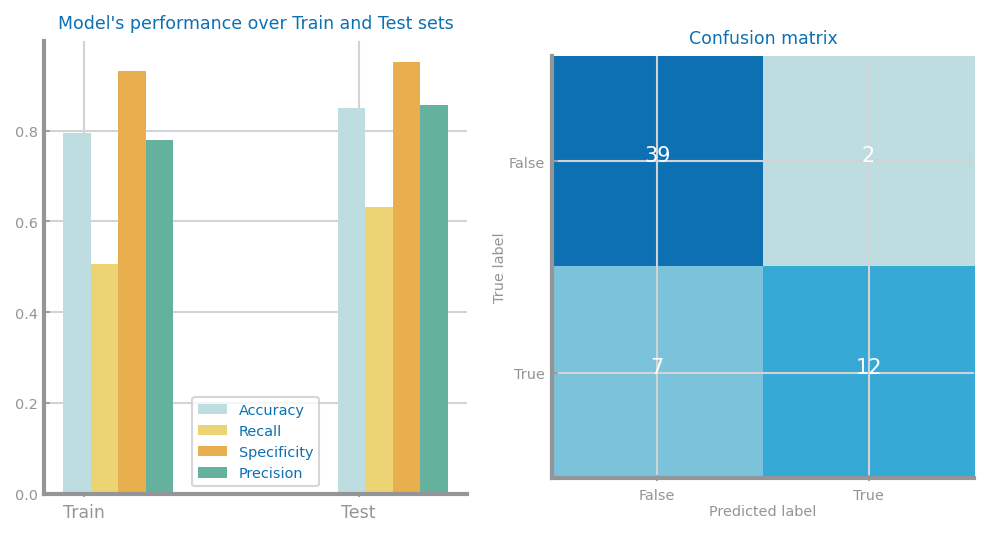

In [13]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

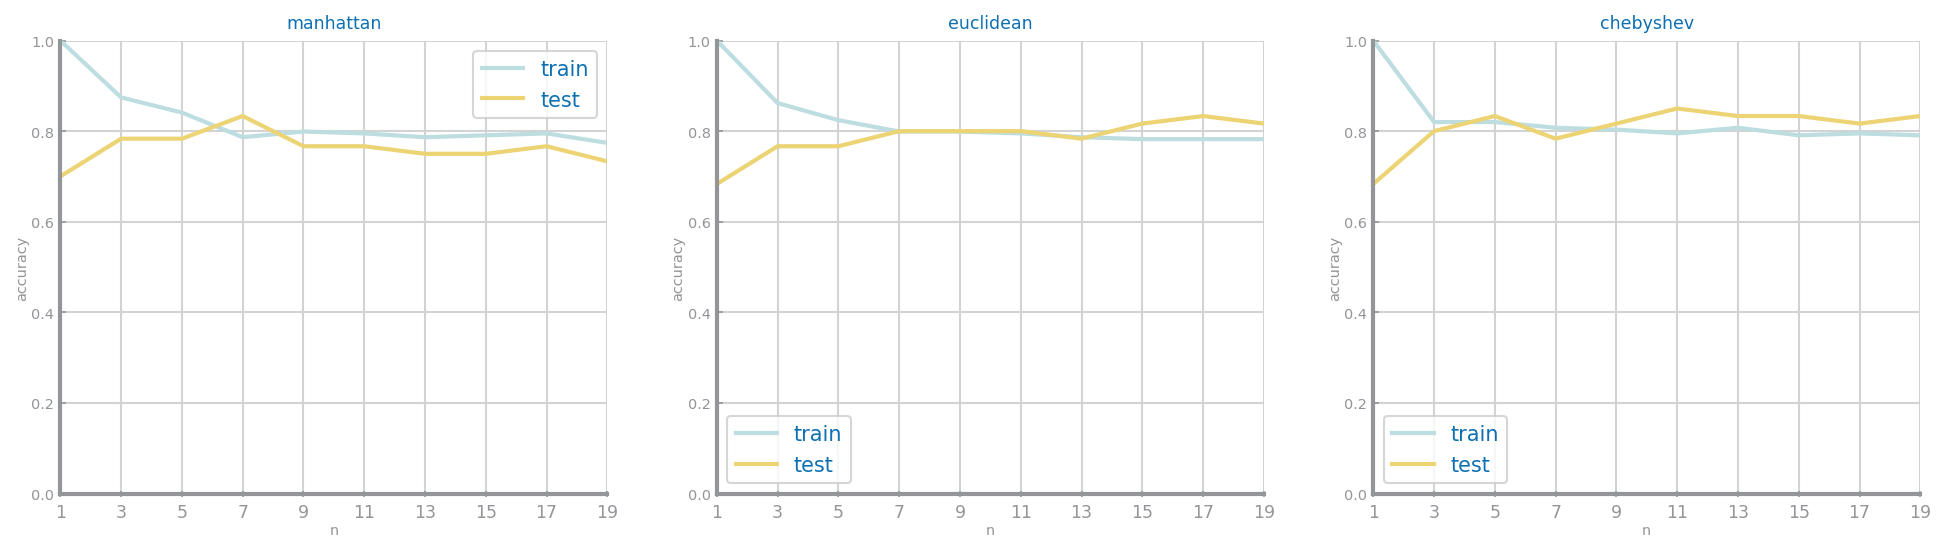

In [14]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
for i in range(len(dist)):
    ds.multiple_line_chart(nvalues, {'train': train_values[dist[i]], 'test': values[dist[i]]}, ax=axs[0, i], title=dist[i], xlabel='n', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'>Decision Trees - ZScore</font>


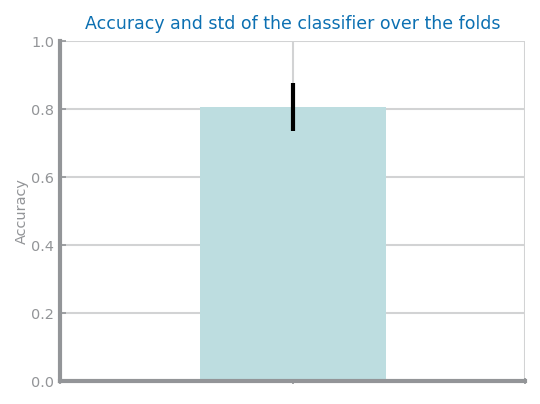

In [15]:
from sklearn.tree import DecisionTreeClassifier

score_all = []
set_idxs = []

for trnX, tstX, trnY, tstY in splits:
    set_idxs.append([trnX, tstX, trnY, tstY])
    min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
    max_depths = [2, 5, 10, 15, 20, 25]
    criteria = ['entropy', 'gini']
    best = ('',  0, 0.0)
    last_best = 0
    best_tree = None

    criteria_test_values = {}
    criteria_train_values = {}

    for k in range(len(criteria)):
        f = criteria[k]
        values = {}
        train_values = {}
        for d in max_depths:
            yvalues = []
            y_trn_values = []
            for imp in min_impurity_decrease:
                tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(trnX, trnY)
                prdY = tree.predict(tstX)
                prd_trn_Y = tree.predict(trnX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
                if yvalues[-1] > last_best:
                    best = (f, d, imp)
                    last_best = yvalues[-1]
                    best_tree = tree

            values[d] = yvalues
            train_values[d] = y_trn_values
        
        criteria_test_values[f] = values
        criteria_train_values[f] = train_values
    score_all.append(last_best)

best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]

score_all = []
for trnX, tstX, trnY, tstY in splits:
    tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=best[1], criterion=best[0], min_impurity_decrease=best[2])
    tree.fit(trnX, trnY)
    prdY = knn.predict(tstX)
    prd_trn_Y = knn.predict(trnX)
    score_all.append(metrics.accuracy_score(tstY, prdY))

fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()


<Figure size 600x450 with 0 Axes>

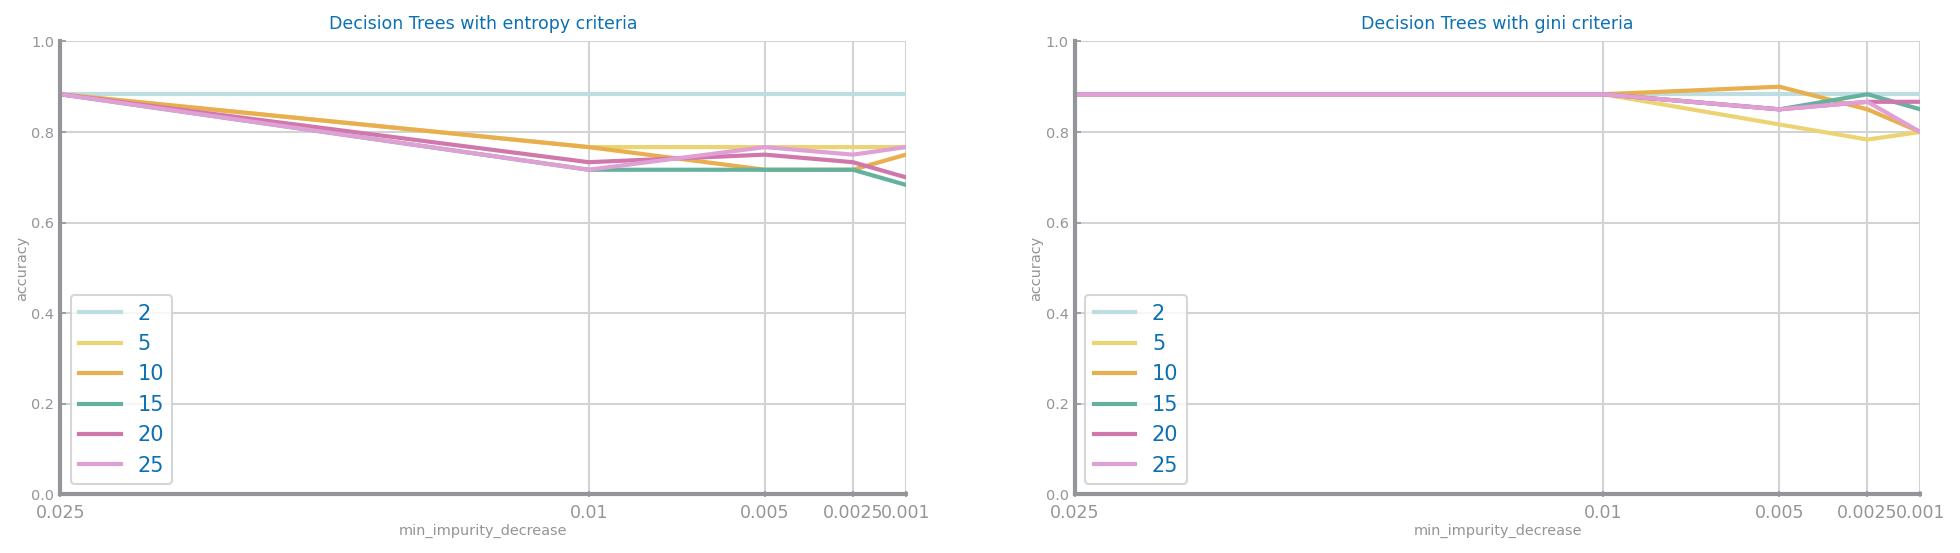

Best results achieved with gini criteria, depth=10 and min_impurity_decrease=0.01 ==> accuracy=0.90


In [16]:
from sklearn.tree import DecisionTreeClassifier

trnX, tstX, trnY, tstY = set_idxs
min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

criteria_test_values = {}
criteria_train_values = {}

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    train_values = {}
    for d in max_depths:
        yvalues = []
        y_trn_values = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            prd_trn_Y = tree.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
        train_values[d] = y_trn_values
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
    
    criteria_test_values[f] = values
    criteria_train_values[f] = train_values
    

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

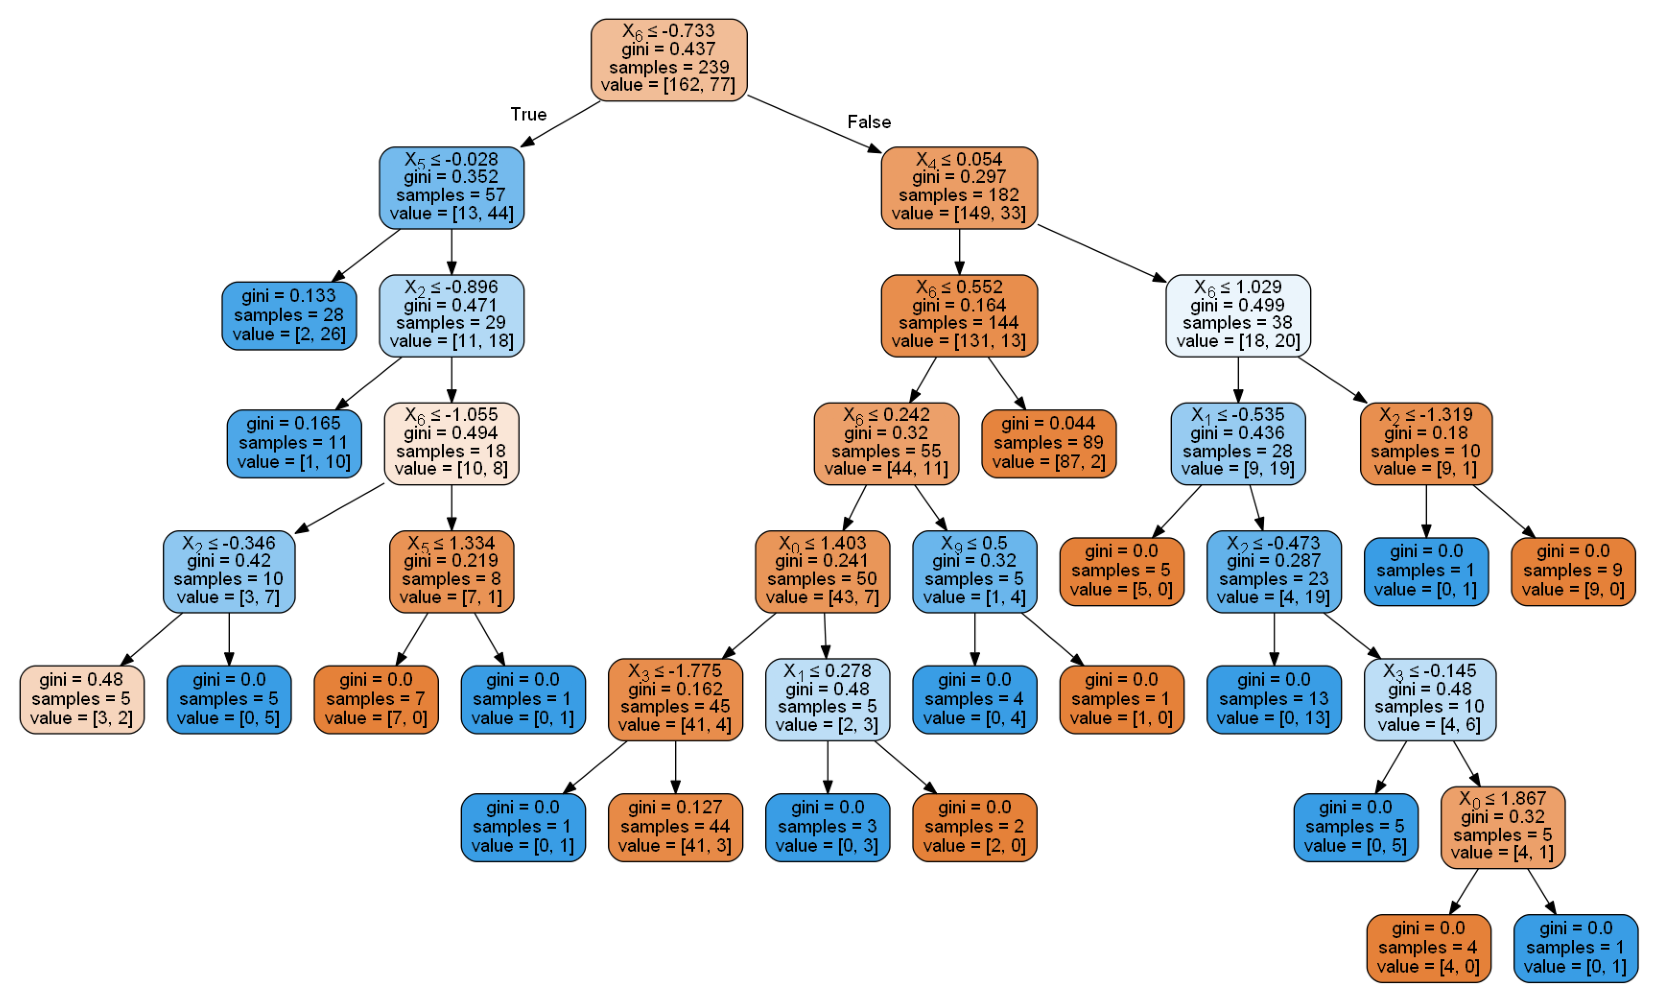

In [17]:
from sklearn.tree import export_graphviz
import pydot

dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
(graph,) = pydot.graph_from_dot_file('dtree.dot')
graph.write_png('dtree.png')

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

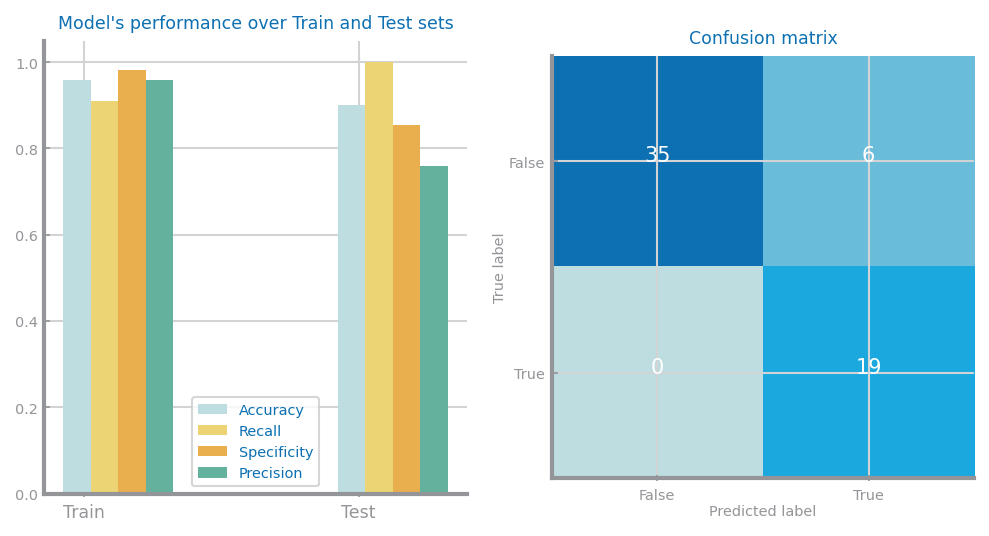

In [18]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

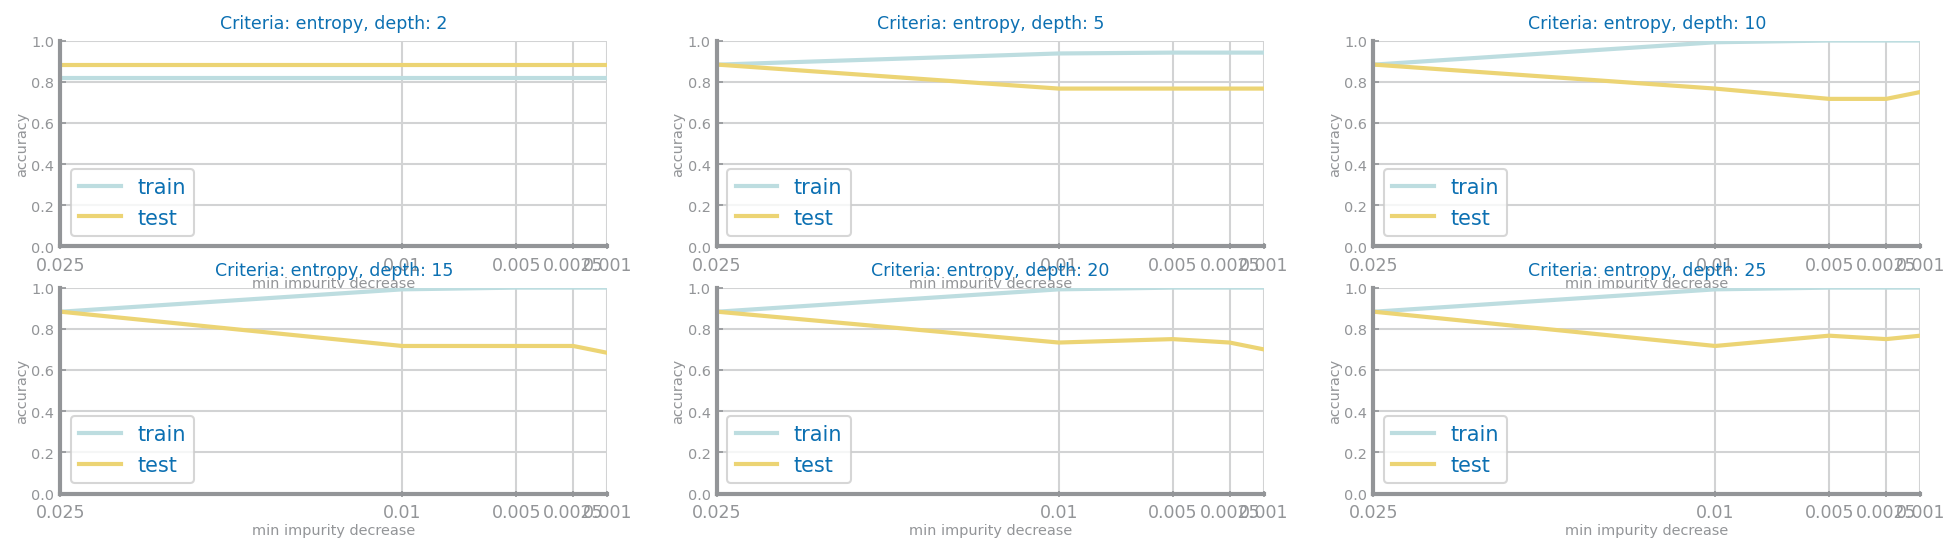

<Figure size 600x450 with 0 Axes>

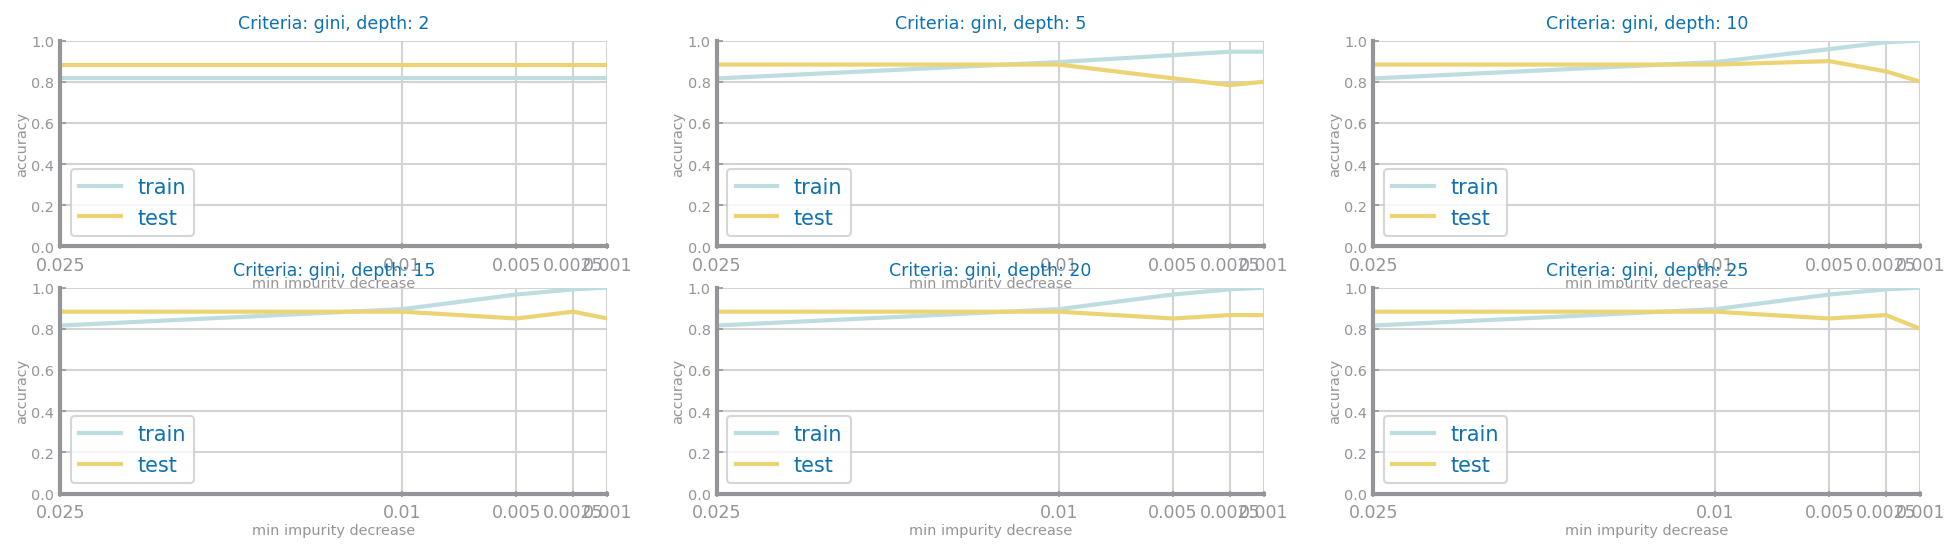

In [19]:
for j in range(len(criteria)):
    train_values = criteria_train_values[criteria[j]]
    test_values = criteria_test_values[criteria[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_depths)):
        ds.multiple_line_chart(min_impurity_decrease, {'train': train_values[max_depths[i]], 'test': test_values[max_depths[i]]}, ax=axs[int(i/3), i%3], title='Criteria: ' + criteria[j]+ ', depth: ' + str(max_depths[i]), xlabel='min impurity decrease', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Random Forests - ZScore Data</font>

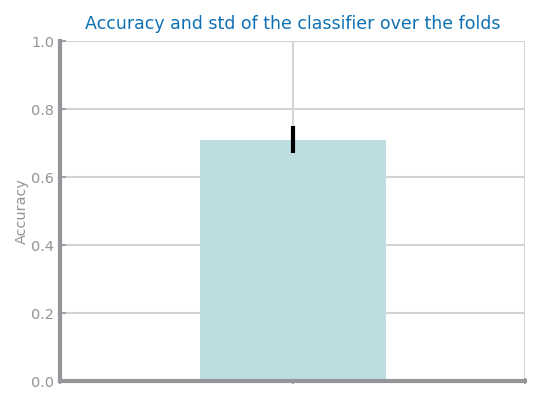

In [20]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

score_all = []
set_idxs = []
for trnX, tstX, trnY, tstY in splits:
    set_idxs.append([trnX, tstX, trnY, tstY])

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    max_features = [.1, .3, .5, .7, .9, 1]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    max_depth_test_values = {}
    max_depth_train_values = {}

    cols = len(max_depths)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        train_values = {}
        for f in max_features:
            yvalues = []
            y_trn_values = []
            for n in n_estimators:
                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                prd_trn_y = rf.predict(trnX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
                if yvalues[-1] > last_best:
                    best = (d, f, n)
                    last_best = yvalues[-1]
                    best_tree = rf

            values[f] = yvalues
            train_values[f] = y_trn_values

        max_depth_test_values[max_depths[k]] = values
        max_depth_train_values[max_depths[k]] = train_values

    score_all.append(last_best)


best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]
    
score_all = []
for trnX, tstX, trnY, tstY in splits:
    rf = RandomForestClassifier(n_estimators=best[2], max_depth=best[0], max_features=best[1])
    rf.fit(trnX, trnY)
    prdY = rf.predict(tstX)
    prd_trn_y = rf.predict(trnX)
    score_all.append(metrics.accuracy_score(tstY, prdY))
    
fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()

<Figure size 600x450 with 0 Axes>

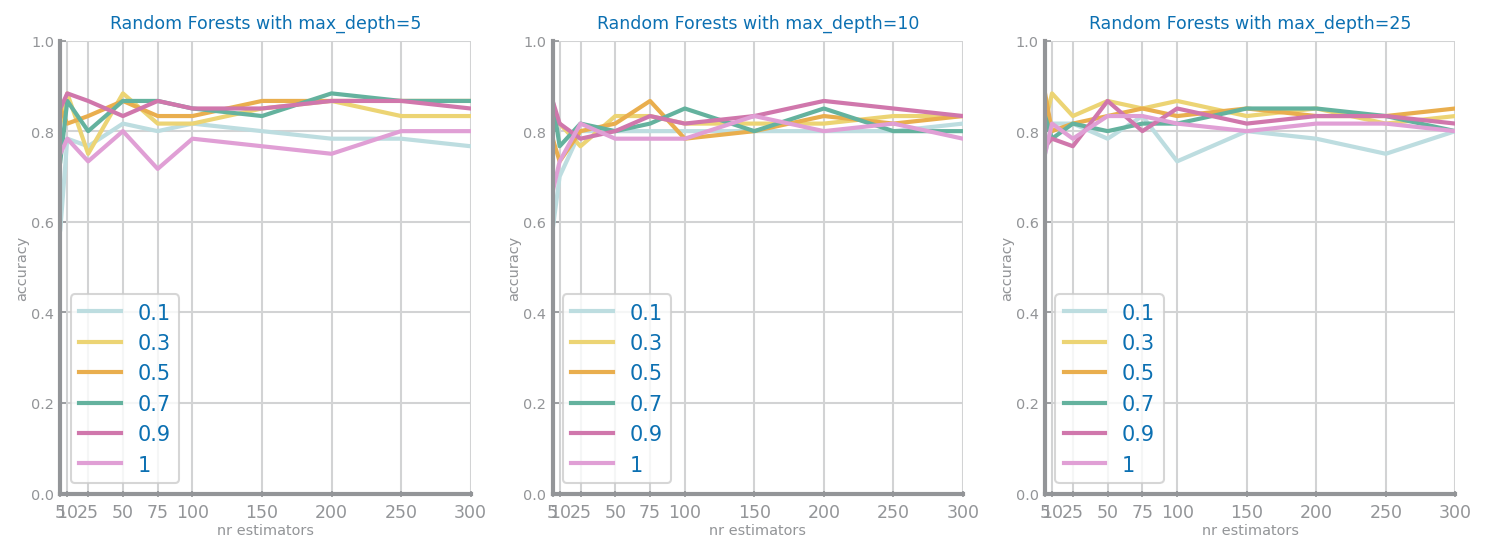

Best results with depth=5, 0.30 features and 10 estimators, with accuracy=0.88


In [21]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

trnX, tstX, trnY, tstY = set_idxs
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None


max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for f in max_features:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            prd_trn_y = rf.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        train_values[f] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values
    
    
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

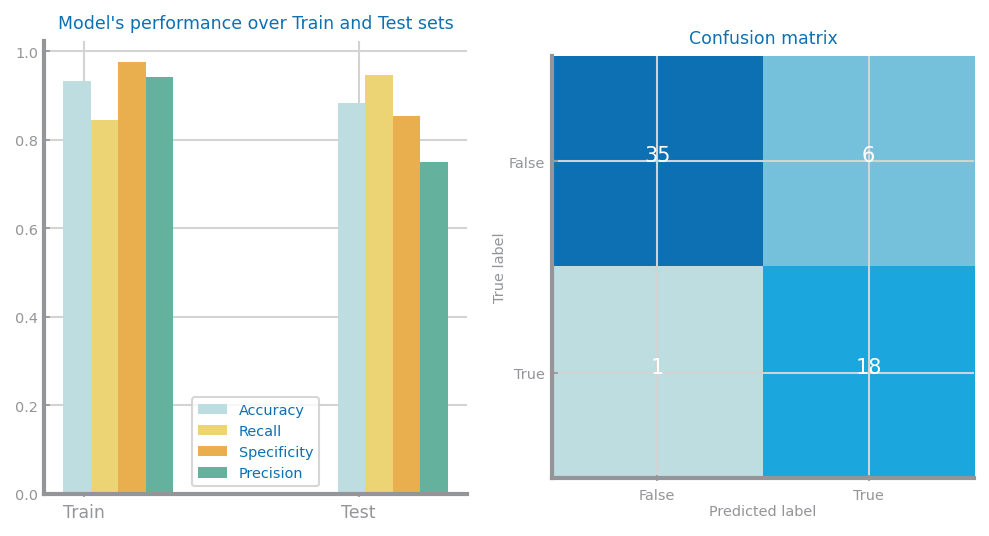

In [22]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

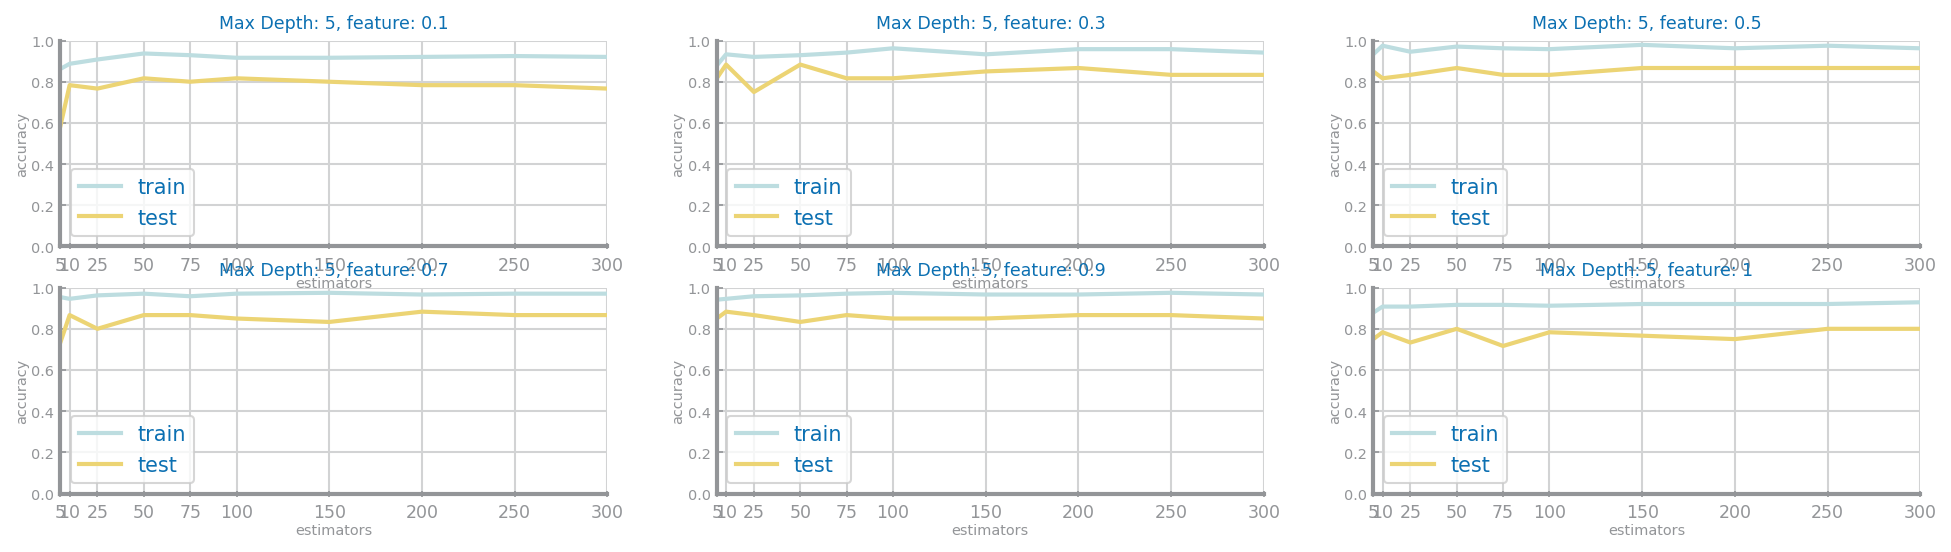

<Figure size 600x450 with 0 Axes>

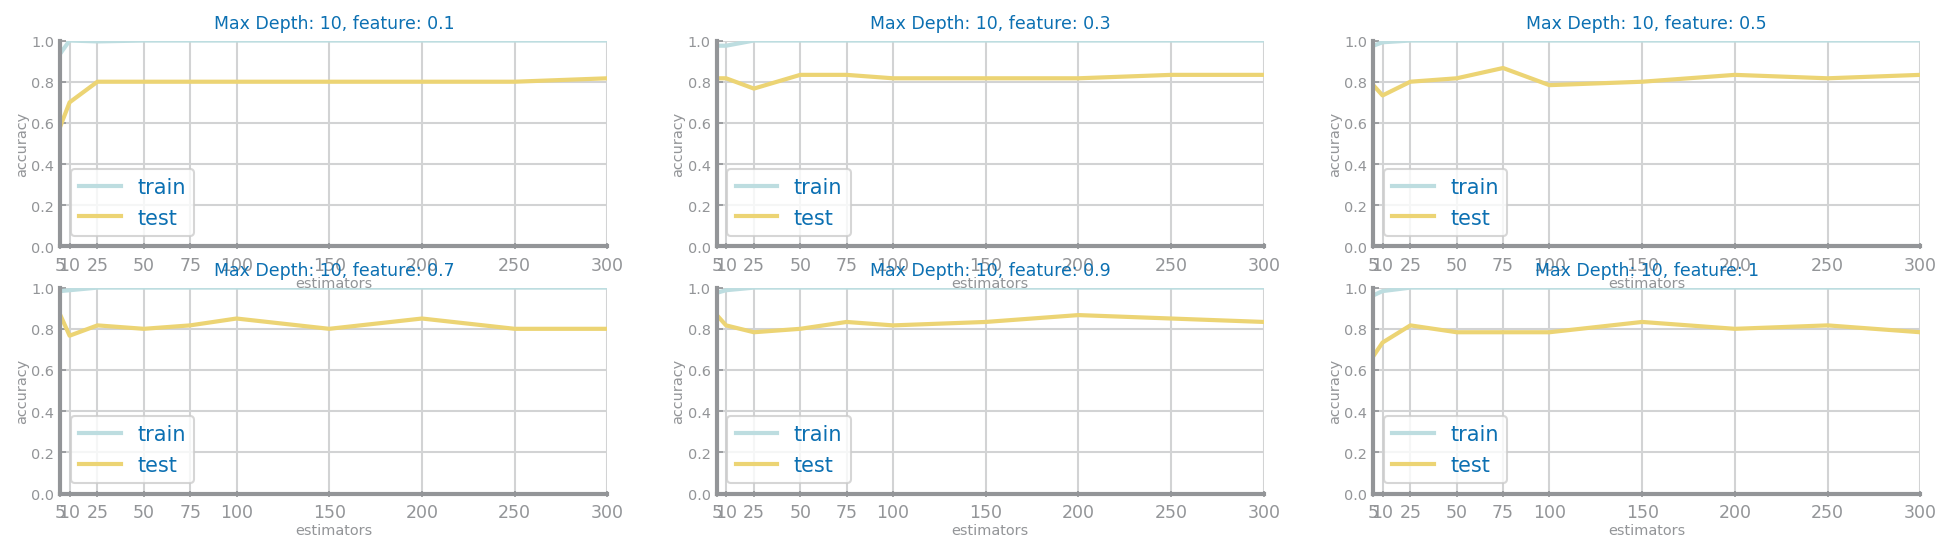

<Figure size 600x450 with 0 Axes>

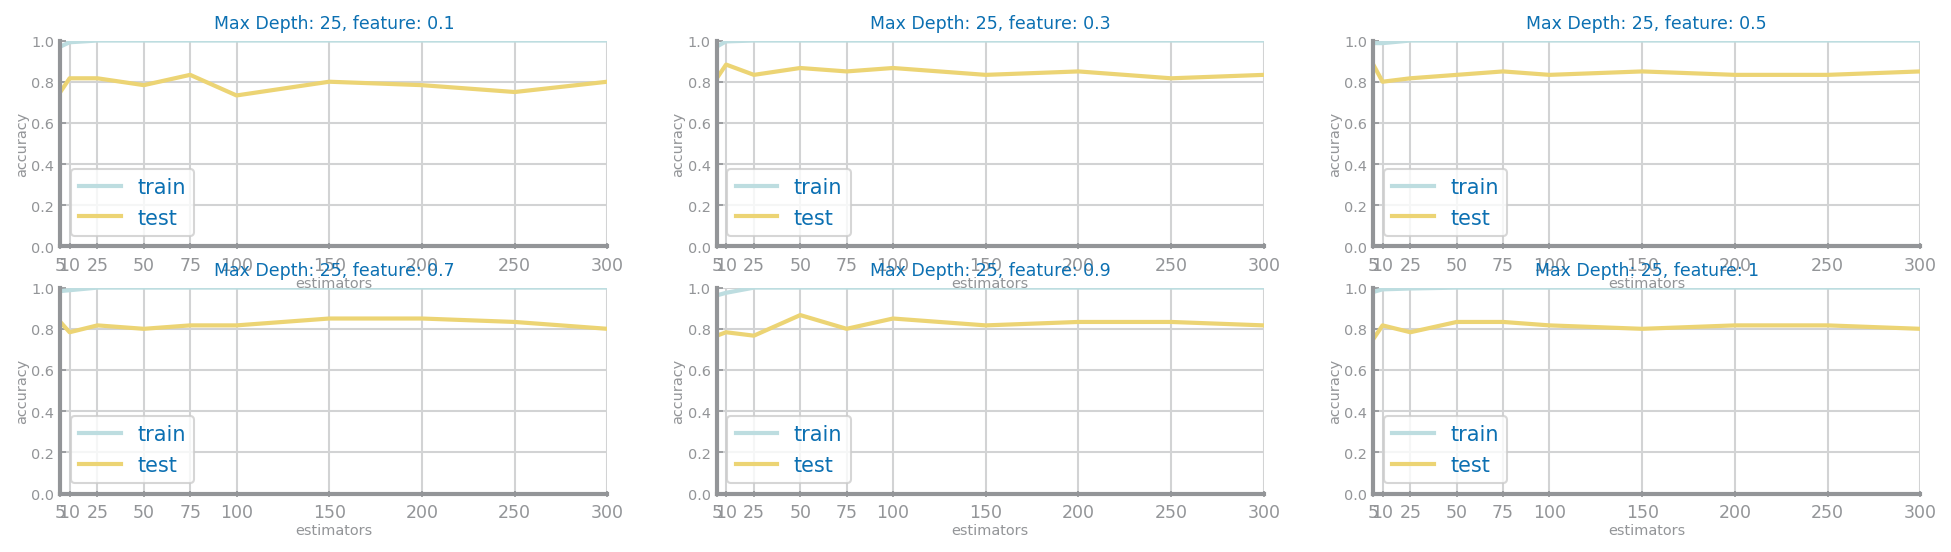

In [23]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_features)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[max_features[i]], 'test': test_values[max_features[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(max_features[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Logistic Regression - ZScore</font>

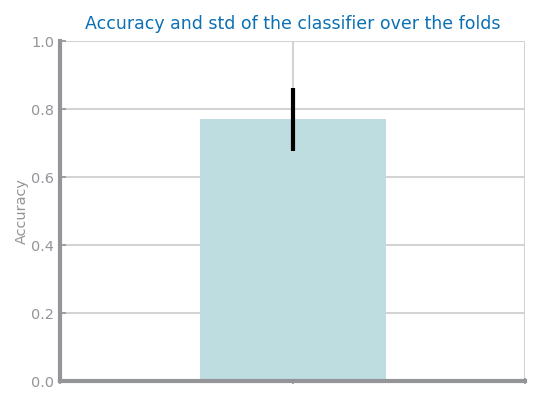

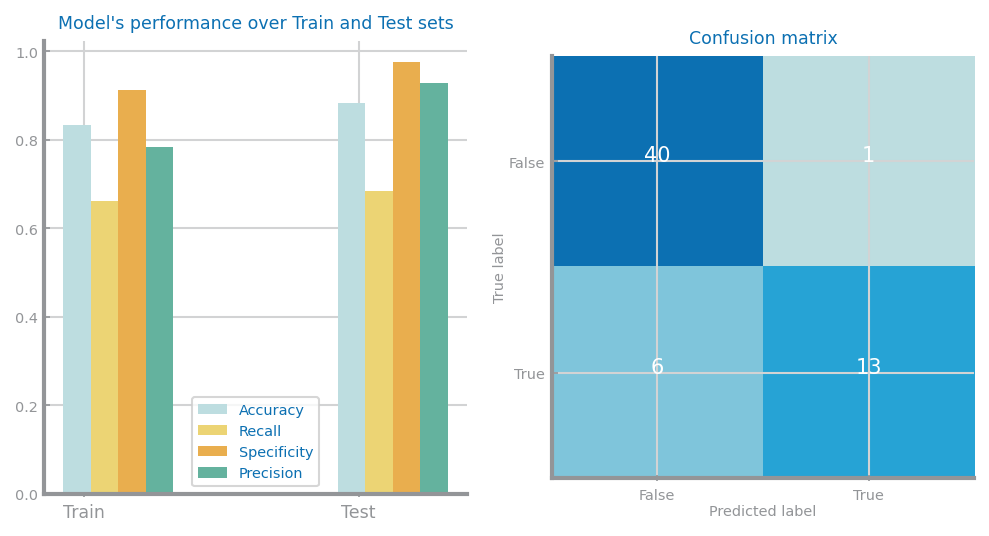

In [24]:
from sklearn.linear_model import LogisticRegression

y_hat_all = []
score_all = []
models = []
set_idxs = []
for trnX, tstX, trnY, tstY in splits:
    clf = LogisticRegression(random_state = 0)
    set_idxs.append([trnX, tstX, trnY, tstY])
    clf = clf.fit(trnX, trnY)
    models.append(clf)
    y_hat = clf.predict(trnX)
    y_hat_all.append(y_hat)
    score_all.append(clf.score(tstX, tstY))

best_model_idx = score_all.index(max(score_all))
best_model = models[best_model_idx]
set_idxs = set_idxs[best_model_idx]
prd_trn = best_model.predict(set_idxs[0])
prd_tst = best_model.predict(set_idxs[1])

fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()

ds.plot_evaluation_results(labels, set_idxs[2], prd_trn, set_idxs[3], prd_tst)

# <font color='gray'>Gradient Boosting - Zscore</font>

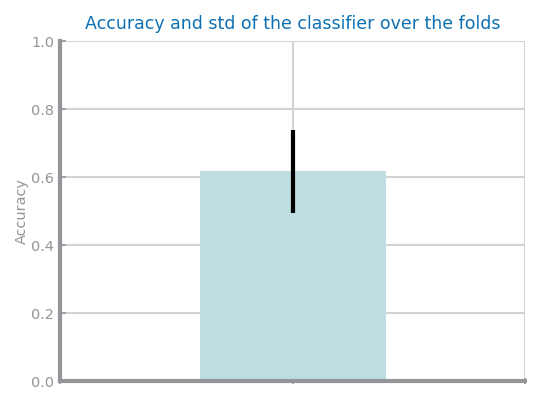

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

score_all = []
set_idxs = []
for trnX, tstX, trnY, tstY in splits:
    set_idxs.append([trnX, tstX, trnY, tstY])
    
    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    cols = len(max_depths)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX, trnY)
                prdY = gb.predict(tstX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (d, lr, n)
                    last_best = yvalues[-1]
                    best_tree = gb
            values[lr] = yvalues
            
    score_all.append(last_best)


best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]

score_all = []
for trnX, tstX, trnY, tstY in splits:
    gb = GradientBoostingClassifier(n_estimators=best[2], max_depth=best[0], learning_rate=best[1])
    gb.fit(trnX, trnY)
    prdY = gb.predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))
    score_all.append(metrics.accuracy_score(tstY, prdY))

fig, ax = plt.subplots()
ax.bar(1, sum(score_all)/len(score_all), yerr=np.std(score_all), align='center')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['','','',''])
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Accuracy and std of the classifier over the folds')
ax.yaxis.grid(True)
plt.show()

<Figure size 600x450 with 0 Axes>

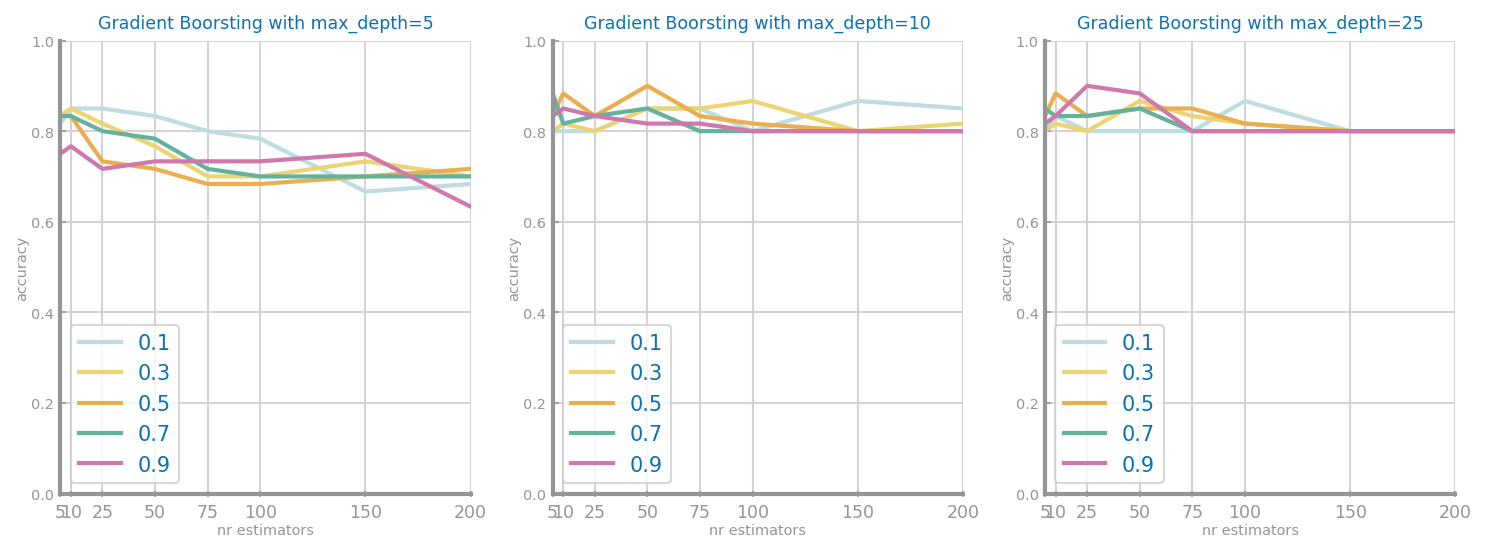

Best results with depth=10, learning rate=0.50 and 50 estimators, with accuracy=0.90


In [26]:
trnX, tstX, trnY, tstY = set_idxs

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]
best = ('', 0, 0)
last_best = 0
best_tree = None

max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for lr in learning_rate:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            prd_trn_y = gb.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_tree = gb
        values[lr] = yvalues
        train_values[lr] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values

plt.show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

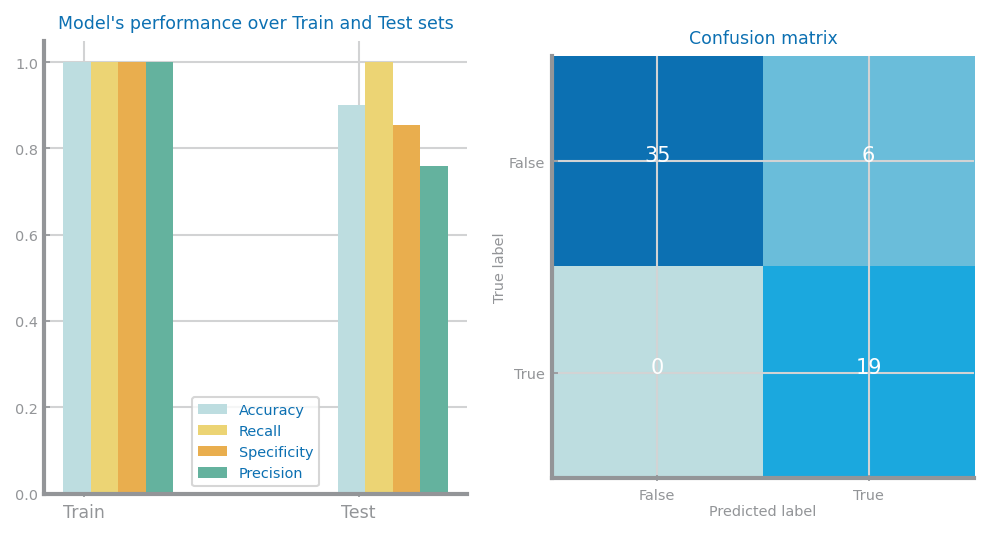

In [27]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

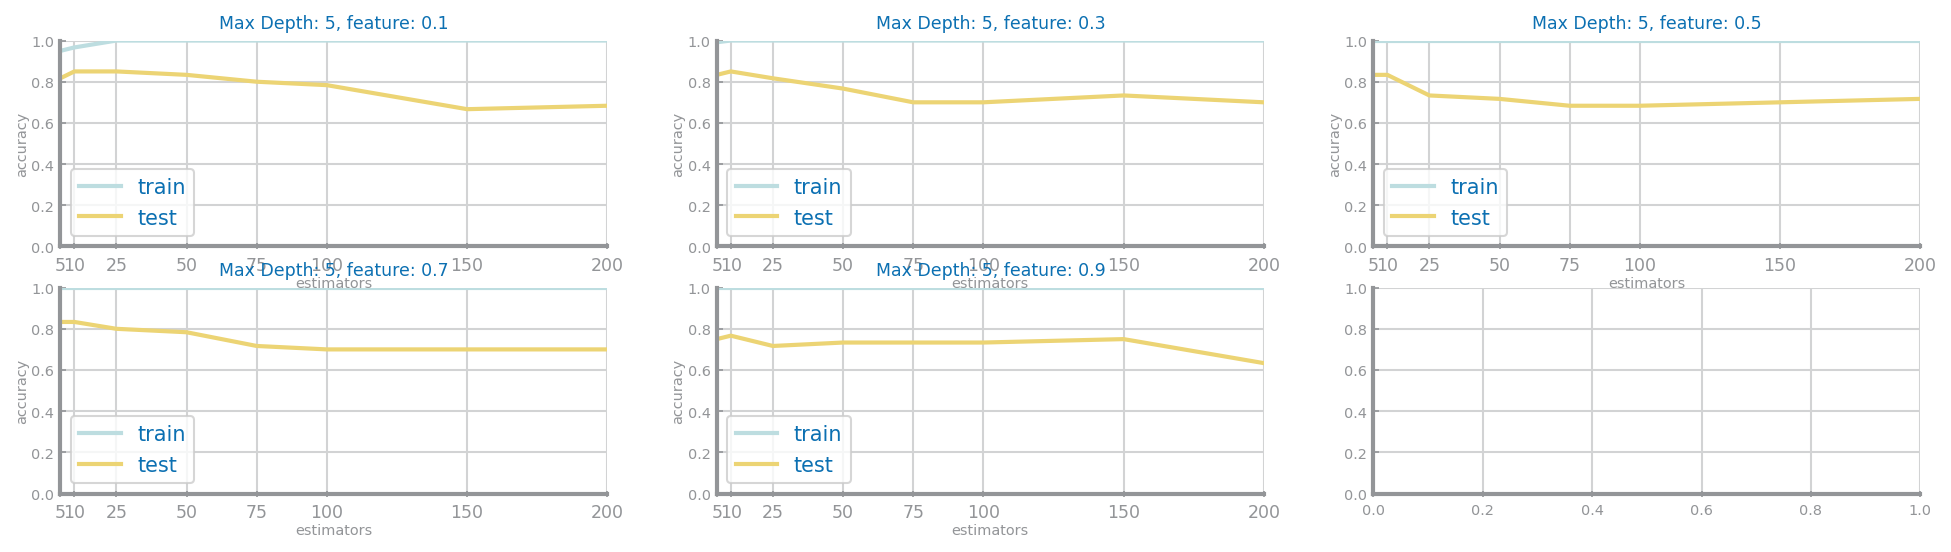

<Figure size 600x450 with 0 Axes>

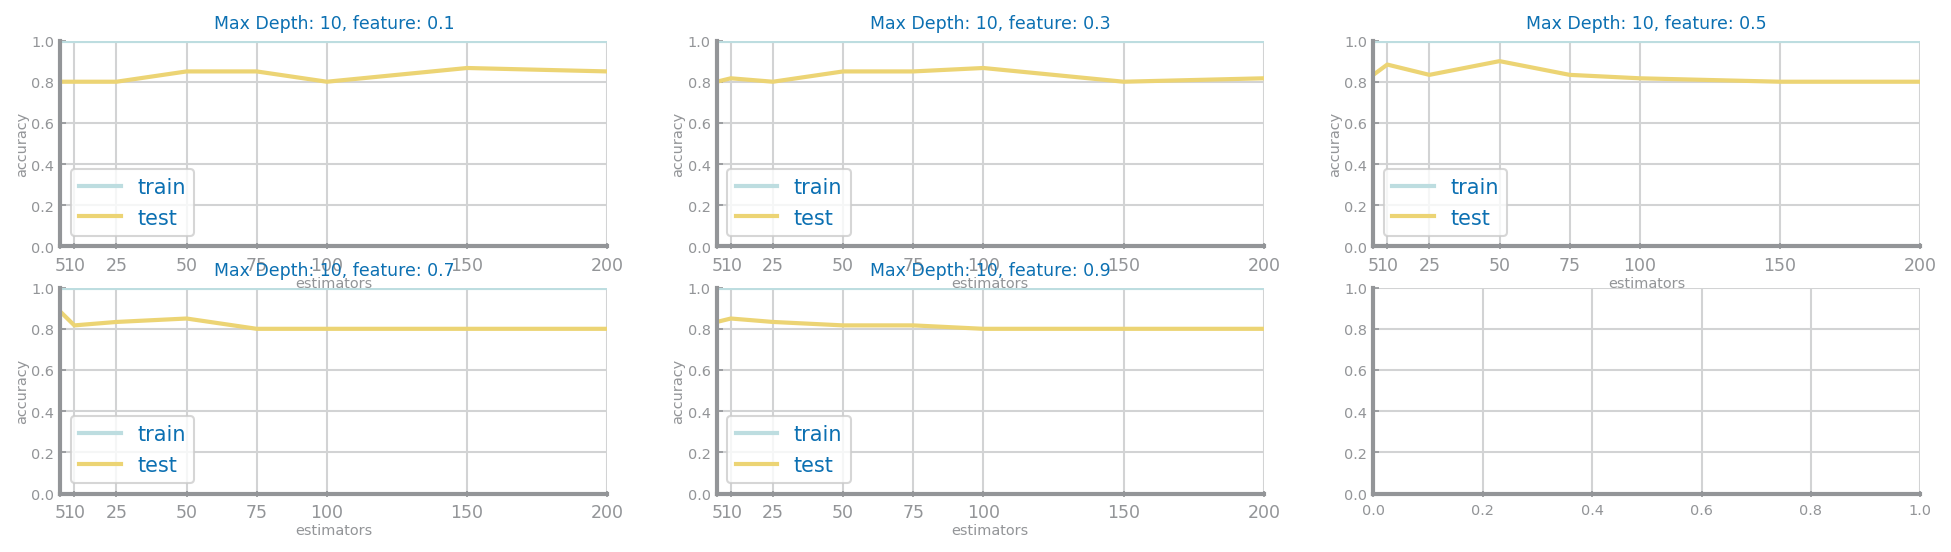

<Figure size 600x450 with 0 Axes>

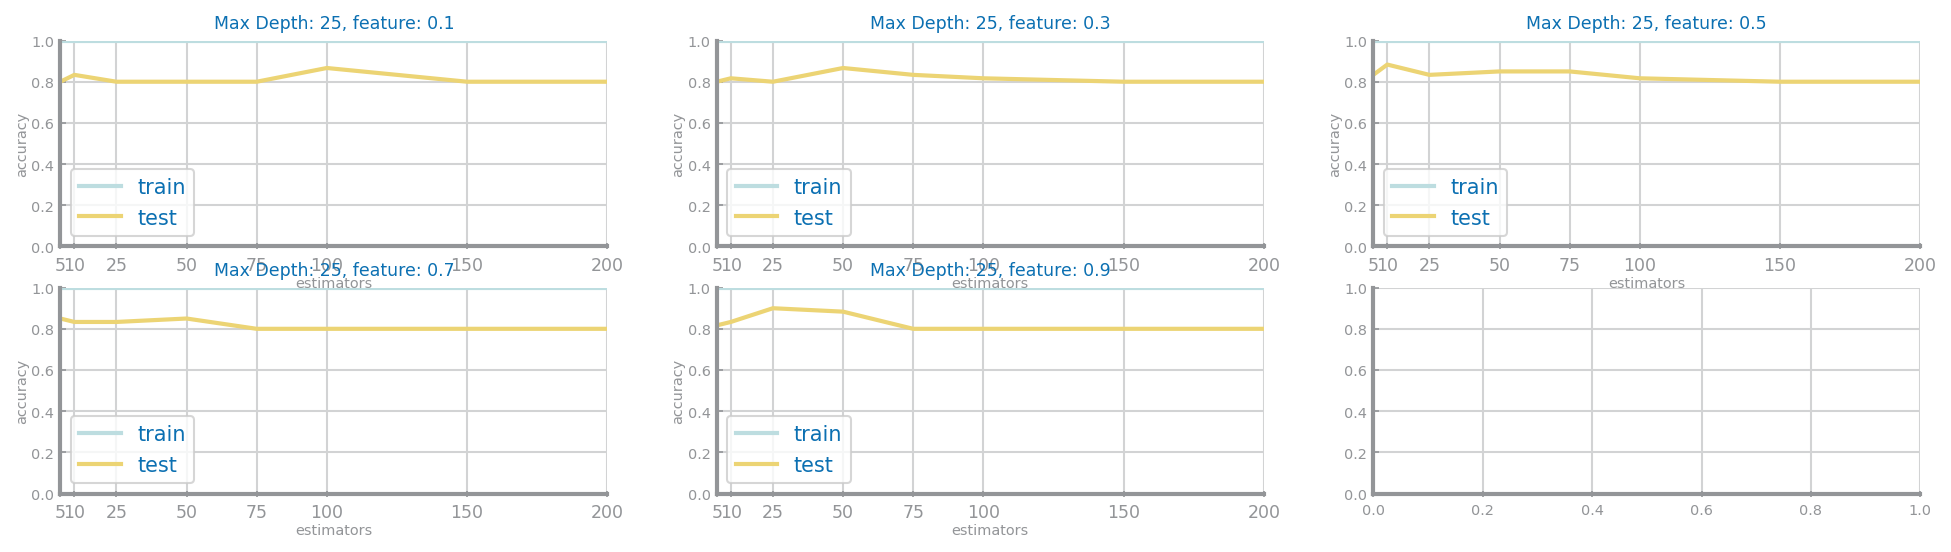

In [28]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(learning_rate)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[learning_rate[i]], 'test': test_values[learning_rate[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(learning_rate[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()